# Dual Channel Simultanuous Transmission :


## Setting up the environment:

* import required python modules
* Load the bitfile containing the block design



In [2]:
from pynq import Overlay
import iotSDR.iotSDR_streams as SDR
import iotSDR.iotSDR_defs as channels

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

iot_overlay = Overlay('../bitstream/iotSDR_IOT.bit',download=True)

In [3]:
iotSDR = SDR.iotSDR_stream(iot_overlay)

tx_chan1   = channels.chan_subGHz_A
tx_chan2   = channels.chan_subGHz_B

#tx_chan   = iotSDR_defs.chan_24GHz_B
#rx_chan   = iotSDR_defs.chan_24GHz_A

## Setting iotSDR Frequency
- Center Frequency of the 

In [4]:
cent_frequency_kHz = 918e6  # channel carrier freq 
chan_spacing_kHz   = 25     # channel spacing w.r.t carrier freq
chan_number        = 1      # channel offset in multiple of channel spacing w.r.t carrier freq

iotSDR.setFrequency(tx_chan1,cent_frequency_kHz,chan_spacing_kHz,chan_number)
iotSDR.setFrequency(tx_chan2,cent_frequency_kHz,chan_spacing_kHz,chan_number+200)


iotSDR Device: frequency:918000 updated for channel:0 
iotSDR Device: frequency:918000 updated for channel:2 


In [6]:
cyclic_mode = True
tx_stream_1 = iotSDR.initStream(channels.IOTSDR_TX,tx_chan1,cyclic_mode)
tx_stream_2 = iotSDR.initStream(channels.IOTSDR_TX,tx_chan2,cyclic_mode)
iotSDR.activateStream(tx_stream_1)
iotSDR.activateStream(tx_stream_2)

iotSDR Device: Channel: chan_subGHz_A Tx stream setup 
iotSDR Device: Channel: chan_subGHz_B Tx stream setup 


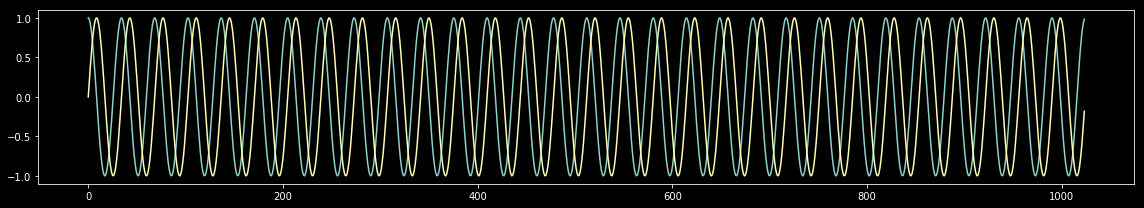

In [7]:

import time
import numpy as np


f = 30 #Hz
N = 1*1024

t = np.linspace(0, 1, N,endpoint=False)
real = np.cos(2*np.pi*f*t)*1
imag = np.sin(2*np.pi*f*t)*1

tx_samples = real + 1j*imag


fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(16,3))

n = np.arange(0, N, 1)
axes.plot(n, tx_samples.real[:])
axes.plot(n, tx_samples.imag[:])

plt.tight_layout()
plt.show()


In [8]:
"""
Create continous memory buffer for DAC transmit samples
this buffer will be filled up by the streamed samples and transmitted through the RF chip
"""
from pynq import allocate 

totalSamples    = len(tx_samples)
ADC_SAMPLE_BITs = 14

tx_sample_buffer = allocate(shape=(totalSamples*2,), dtype=np.int16)

tx_sample_buffer[0::2] = (2**ADC_SAMPLE_BITs-1)* tx_samples.real
tx_sample_buffer[1::2] = (2**ADC_SAMPLE_BITs-1)* tx_samples.imag


In [9]:
iotSDR.writeStream(tx_stream_1,tx_sample_buffer)
iotSDR.writeStream(tx_stream_2,tx_sample_buffer)


Transmission Buffer updated in continous cyclic Mode
Transmission Buffer updated in continous cyclic Mode


In [10]:
tx_sample_buffer.close()
iotSDR.deactivateStream(tx_stream_1)
iotSDR.deactivateStream(tx_stream_2)